In [63]:
import csv
import ast
import math
import pickle
import random
import numpy as np
import copy
from collections import Counter
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [56]:
import sklearn.preprocessing as prepr
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

<h3> Load movie-features dictionary </h3>

In [ ]:
movies_with_details_dic = pickle.load(open('movies_with_details_dic', 'rb'))

In [ ]:
user_ratings = pickle.load(open("Dataset\\user_ratings_dict",'rb'))

In [47]:
len(user_ratings)

6000

<h3>Functions to generate movie docs for generating tf-idf vecctors</h3>

In [31]:
def get_f_doc(movie_data, f1_features, a):
    g1 = f1_features
    l1 = []
    mapping = []
    for i in movie_data.keys():
        mapping.append(i)
        movie = movie_data[i]
        temp_doc = ''
        for j in range(len(g1)):
            if g1[j] == 'actors':
                for k in range(a):
                    try:
                        if len(temp_doc) == 0:
                            temp_doc += movie[g1[j]][k]
                        else:
                            temp_doc += ' ' + movie[g1[j]][k]
                    except:
                        break
            elif g1[j] == 'overview':
                if len(temp_doc) == 0:
                    temp_doc += movie[g1[j]]
                else:
                    temp_doc += ' ' + movie[g1[j]]
            else:
                for lm in range(len(movie[g1[j]])):
                    if len(temp_doc) == 0:
                        temp_doc += movie[g1[j]][lm]
                    else:
                        temp_doc += ' ' + movie[g1[j]][lm]
        l1.append(temp_doc)
    return l1, mapping

<h3>Generate tf-idf vectors and similarity matrix from movie docs</h3>

In [14]:
def get_tf_idf_vecs_from_docs(doc_data):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(doc_data)
    Y = X.toarray()
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf = transformer.fit_transform(Y)
    tf_idf_vecs = tfidf.toarray()
    return tf_idf_vecs

In [32]:
f_features = ['actors','directors','keyterms','genres', 'countries', 'overview']
f_docs, mapping = get_f_doc(movies_with_details_dic, f_features, 10)
f_tf_idf_vecs = get_tf_idf_vecs_from_docs(f_docs)

In [ ]:
with open("f_tf_idf_vecs", 'wb') as fp:
    pickle.dump(f_tf_idf_vecs, fp)

In [34]:
with open("mapping", 'wb') as fp:
    pickle.dump(mapping, fp)

<h3>Train, Test and Plot functions</h3>

In [51]:
def user_pred_errors(user_ratings, k, mapping, f_tf_idf_vecs):
    movie_ids = list(user_ratings.keys())
    if len(movie_ids) < 5:
        return []
    np.random.shuffle(movie_ids)
    train_pts = len(movie_ids) - int(0.2 * len(movie_ids))
    
    train_ratings = np.array([str(user_ratings[mid]) for mid in movie_ids[:train_pts]])
    train_vecs = [f_tf_idf_vecs[mapping.index(mid)] for mid in movie_ids[:train_pts]]
    
    test_ratings = np.array([user_ratings[mid] for mid in movie_ids[train_pts:]])
    test_vecs = [f_tf_idf_vecs[mapping.index(mid)] for mid in movie_ids[train_pts:]]
    
    errors = []
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(train_vecs, train_ratings)
    predictions = knn.predict(test_vecs)
    
    errors = [(float(predictions[i]) - test_ratings[i])**2 for i in range(len(predictions))]
    return errors

In [38]:
def testing(test_user_dict, mapping, f_tf_idf_vecs): 
    k_rmses = []
    for k in range(1,5):
        error = []
        for j in test_user_dict.keys():
            error += user_pred_errors(test_user_dict[j], k, mapping, f_tf_idf_vecs)
        error = np.array(error)
        mean_all = np.mean(error)
        rmse = mean_all ** 0.5
        print(k, '  ', rmse)
        k_rmses.append(rmse)
    return k_rmses

In [1]:
def get_plot(x, y, axis_names=['x-axis','y-axis'], title = '', dim_list = []):
    plt.figure(figsize=(12,5))
    plt.plot(x, y) 
    plt.xlabel(axis_names[0])
    plt.ylabel(axis_names[1])
    plt.xticks(x)
    plt.title(title,fontweight='bold')
    if dim_list:
        for i, txt in enumerate(dim_list):
            plt.annotate(txt, (x[i], y[i]))
    plt.grid()
    plt.show()

In [45]:
np.linalg.norm(f_tf_idf_vecs[0])

1.0

In [43]:
normalized_tfidf = prepr.normalize(f_tf_idf_vecs)

In [52]:
k_rmses = testing(user_ratings, mapping, normalized_tfidf)

1    1.3335983658152513
2    1.3780396639049404
3    1.4170260955940301
4    1.3586000907512148


In [109]:
x = PrettyTable()
x.field_names = ["K", "Feature Dim", "Test RMSE"]
for i in range(4):
    x.add_row([str(i+1), normalized_tfidf.shape[1], round(k_rmses[i], 4)])
print(x)

+---+-------------+-----------+
| K | Feature Dim | Test RMSE |
+---+-------------+-----------+
| 1 |    52257    |   1.3336  |
| 2 |    52257    |   1.378   |
| 3 |    52257    |   1.417   |
| 4 |    52257    |   1.3586  |
+---+-------------+-----------+


In [58]:
def get_test_data_pca(tf_idf_vecs, eig_energy_all, evecs_all, mapping, user_rating):
    eig_energy = np.arange(0.50, 1.0, 0.05)
    eig_energy = np.append(eig_energy, [0.99])
    best_test_rmse = math.inf
    k_val, test_rmse_list, eig_en_list, dim_list = [], [], [], []
    
    for lambda_val in eig_energy:
        count = 0
        lambda_val_first = eig_energy_all[0]
        while lambda_val_first < lambda_val:
            count += 1
            lambda_val_first += eig_energy_all[count]
        eig_vecs = evecs_all[:count + 1]
        pca_transformed = np.matmul(tf_idf_vecs, eig_vecs.T)
        normalized_pca_transformed = prepr.normalize(pca_transformed)
        k_rmses = testing(user_rating, mapping, normalized_pca_transformed)
        print("Eigen energy: %8.5f" %(lambda_val_first))
        test_rmse = min(k_rmses)
        if test_rmse < best_test_rmse:
            best_test_rmse = test_rmse
            best_pca_transformed = copy.deepcopy(normalized_pca_transformed)
        eig_en_list += [round(lambda_val_first,4) for i in range(4)]
        k_val += [1,2,3,4]
        test_rmse_list += k_rmses
        dim_list.append(normalized_pca_transformed.shape[1])
        
        print("---------------------------------------------------------------------")
    
    with open("best_pca_transformed", 'wb') as bpt:
        pickle.dump(best_pca_transformed, bpt)
    
    return k_val, test_rmse_list, eig_en_list, dim_list

In [59]:
pca = PCA(n_components=0.99).fit(f_tf_idf_vecs)

In [60]:
evecs_all = pca.components_
eig_energy_all = pca.explained_variance_ratio_

In [61]:
k_val, test_rmse_list, eig_en_list, dim_list = get_test_data_pca(f_tf_idf_vecs, eig_energy_all, evecs_all, mapping, user_ratings)

1    1.3271361598411513
2    1.3779746952333651
3    1.4118428999095993
4    1.360177036019217
Eigen energy:  0.50007
---------------------------------------------------------------------
1    1.333866867296782
2    1.3807926036262186
3    1.4171349009150025
4    1.3613795537440028
Eigen energy:  0.55001
---------------------------------------------------------------------
1    1.3214574533636918
2    1.3699146697700038
3    1.4219613136085425
4    1.3610927273270619
Eigen energy:  0.60019
---------------------------------------------------------------------
1    1.3350185729659099
2    1.3770034093292842
3    1.41821197390536
4    1.3662118052486925
Eigen energy:  0.65014
---------------------------------------------------------------------
1    1.330446891253927
2    1.3751437787458662
3    1.4251058581688267
4    1.357693708445528
Eigen energy:  0.70017
---------------------------------------------------------------------
1    1.327359130626841
2    1.3773320622640606
3    1.4255647

In [78]:
x = PrettyTable()
x.field_names = ["Index", "Var Ratio", "Feature Dim", "K", "Test RMSE"]
for i in range(len(k_val)):
    if int(i % 4) == 0 and i != 0:
        x.add_row(['------', '------', '------', '------', '------'])
    x.add_row([str(i+1),  round(eig_en_list[i], 2), dim_list[int(i % 4)], k_val[i], round(test_rmse_list[i], 4)])
print(x)

+--------+-----------+-------------+--------+-----------+
| Index  | Var Ratio | Feature Dim |   K    | Test RMSE |
+--------+-----------+-------------+--------+-----------+
|   1    |    0.5    |     1189    |   1    |   1.3271  |
|   2    |    0.5    |     1393    |   2    |   1.378   |
|   3    |    0.5    |     1614    |   3    |   1.4118  |
|   4    |    0.5    |     1851    |   4    |   1.3602  |
| ------ |   ------  |    ------   | ------ |   ------  |
|   5    |    0.55   |     1189    |   1    |   1.3339  |
|   6    |    0.55   |     1393    |   2    |   1.3808  |
|   7    |    0.55   |     1614    |   3    |   1.4171  |
|   8    |    0.55   |     1851    |   4    |   1.3614  |
| ------ |   ------  |    ------   | ------ |   ------  |
|   9    |    0.6    |     1189    |   1    |   1.3215  |
|   10   |    0.6    |     1393    |   2    |   1.3699  |
|   11   |    0.6    |     1614    |   3    |   1.422   |
|   12   |    0.6    |     1851    |   4    |   1.3611  |
| ------ |   -

In [2]:
get_plot(threshold_var_list, test_rmse_list, axis_names=['Variance ratio','RMSE'], title = 'Test RMSE vs Variance ratio of eigenvectors of F2 tf-idf vectors', dim_list = dim_list)

NameError: name 'threshold_var_list' is not defined

In [101]:
k_1_rmses = []
var_ratio_1_list = []
for i in range(44):
    if i % 4 == 1:
        k_1_rmses.append(test_rmse_list[i])
        var_ratio_1_list.append(round(eig_en_list[i],2))

In [3]:
get_plot(var_ratio_1_list, k_1_rmses, axis_names=['Variance ratio','RMSE'], title = 'Test RMSE vs Variance ratio for K = 1',  dim_list = dim_list)

NameError: name 'var_ratio_1_list' is not defined

In [4]:
k_4_rmses = []
var_ratio_4_list = []
for i in range(44):
    if i % 4 == 3:
        k_4_rmses.append(test_rmse_list[i])
        var_ratio_4_list.append(round(eig_en_list[i],2))

NameError: name 'test_rmse_list' is not defined

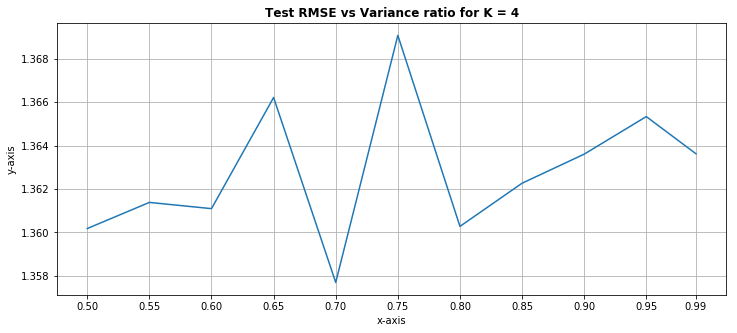

In [106]:
get_plot(var_ratio_4_list, k_4_rmses, axis_names=['x-axis','y-axis'], title = 'Test RMSE vs Variance ratio for K = 4')